In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [2]:
normal_df = pd.read_csv('data/NormalMotorON.csv')
normal_mic_data = normal_df['Volt']
faulty_df = pd.read_csv('data/FaultyMotorON.csv')
faulty_mic_data = faulty_df['Volt']

faulty_df_1 = pd.read_csv('data/ImbalanceMotorON_1.csv')
faulty_mic_data_1 = faulty_df_1['Volt0']
normal_df_1 = pd.read_csv('data/NormalMotorON_1.csv')
normal_mic_data_1 = normal_df_1['Volt0']

In [3]:
sr = 40000
sr_1 = 30000
max_freq = 4000
kaiser_beta = 8
data_interval = 3 # in seconds
ambient_feature_size = 8
motor_feature_size = 8

sr_1 = 30000

def split_in_intervals(mic_data, sampling_rate):
    mic_data_size = mic_data.size
    interval = sampling_rate*data_interval
    remainder = mic_data_size % interval
    num_intervals = mic_data_size//interval
    split_mic_data = np.array(np.split(mic_data.iloc[:mic_data_size-remainder], num_intervals))
    return split_mic_data

def get_fft(mic_data, sampling_rate):
    window = np.kaiser(len(mic_data), 10)
    mic_data = np.multiply(mic_data, window)
    mic_fft = np.fft.rfft(mic_data, norm="forward")
    mic_freq = np.fft.rfftfreq(len(mic_data), 1/sampling_rate)
    return mic_fft, mic_freq

def cut_freq(mic_freq, max_freq):
    indices = np.where(mic_freq <= max_freq)
    mic_freq = mic_freq[indices]
    return mic_freq

def get_fft_of_split_data(split_mic_data, sampling_rate):
    split_mic_fft_amp = []
    split_mic_freq = np.fft.rfftfreq(len(split_mic_data[0]), 1/sampling_rate)
    split_mic_freq = cut_freq(split_mic_freq, max_freq)
    for mic_data in split_mic_data:
        mic_fft, mic_freq = get_fft(mic_data, sampling_rate)
        mic_fft_amplitude = np.abs(mic_fft[:len(split_mic_freq)])
        split_mic_fft_amp.append(mic_fft_amplitude)
    return split_mic_fft_amp, split_mic_freq

def add_type_column(fft_data, result_type):
    if result_type == 'normal':
        result = np.zeros((len(fft_data), 1))
    else:
        result = np.ones((len(fft_data), 1))
    return np.append(fft_data, result, axis=1)

In [4]:
split_normal_mic_data = split_in_intervals(normal_mic_data, sr)
split_faulty_mic_data = split_in_intervals(faulty_mic_data, sr)

split_normal_mic_data_1 = split_in_intervals(normal_mic_data_1, sr_1)
split_faulty_mic_data_1 = split_in_intervals(faulty_mic_data_1, sr_1)

c:\Users\rarora\DataspellProjects\PredictiveAnalysis\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [5]:
normal_split_mic_fft_amp, normal_split_mic_freq = get_fft_of_split_data(split_normal_mic_data, sr)
faulty_split_mic_fft_amp, faulty_split_mic_freq = get_fft_of_split_data(split_faulty_mic_data, sr)

normal_split_mic_fft_amp_1, normal_split_mic_freq_1 = get_fft_of_split_data(split_normal_mic_data_1, sr_1)
faulty_split_mic_fft_amp_1, faulty_split_mic_freq_1 = get_fft_of_split_data(split_faulty_mic_data_1, sr_1)

In [6]:
normal_split_mic_fft_amp = add_type_column(normal_split_mic_fft_amp, 'normal')
faulty_split_mic_fft_amp = add_type_column(faulty_split_mic_fft_amp, 'faulty')

normal_split_mic_fft_amp_1 = add_type_column(normal_split_mic_fft_amp_1, 'normal')
faulty_split_mic_fft_amp_1 = add_type_column(faulty_split_mic_fft_amp_1, 'faulty')

In [7]:
dataset = np.concatenate((normal_split_mic_fft_amp, faulty_split_mic_fft_amp, normal_split_mic_fft_amp_1, faulty_split_mic_fft_amp_1), axis=0)
rand = np.random.default_rng()
rand.shuffle(dataset)
X = dataset[:, :-1]
y = dataset[:, -1]
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.25)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1804, 12001)
(301, 12001)
(301, 12001)


In [8]:
model = keras.Sequential()

In [9]:
input_shape = (X_train.shape[1], 1)
model.add(keras.Input(shape=input_shape))
model.add(keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [10]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 12001, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 6000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6000, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    12,288,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,296,513 (46.91 MB)

 Trainable params: 12,296,513 (46.91 MB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(X_train, y_train, epochs=64, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/64
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.5199 - loss: 0.6921 - val_accuracy: 0.5581 - val_loss: 0.6869
Epoch 2/64
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.5253 - loss: 0.6912 - val_accuracy: 0.5615 - val_loss: 0.6907
Epoch 3/64
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.5200 - loss: 0.6911 - val_accuracy: 0.5581 - val_loss: 0.6880
Epoch 4/64
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.5236 - loss: 0.6920 - val_accuracy: 0.5615 - val_loss: 0.6824
Epoch 5/64
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.5523 - loss: 0.6881 - val_accuracy: 0.5615 - val_loss: 0.6817
Epoch 6/64
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.5496 - loss: 0.6866 - val_accuracy: 0.5615 - val_loss: 0.6796
Epoch 7/64
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.5169 - loss: 0.6885 - val_accuracy: 0.5615 - val_loss: 0.6920
Epoch 8/64
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.4962 - loss: 0.6920 - val_accuracy: 0.

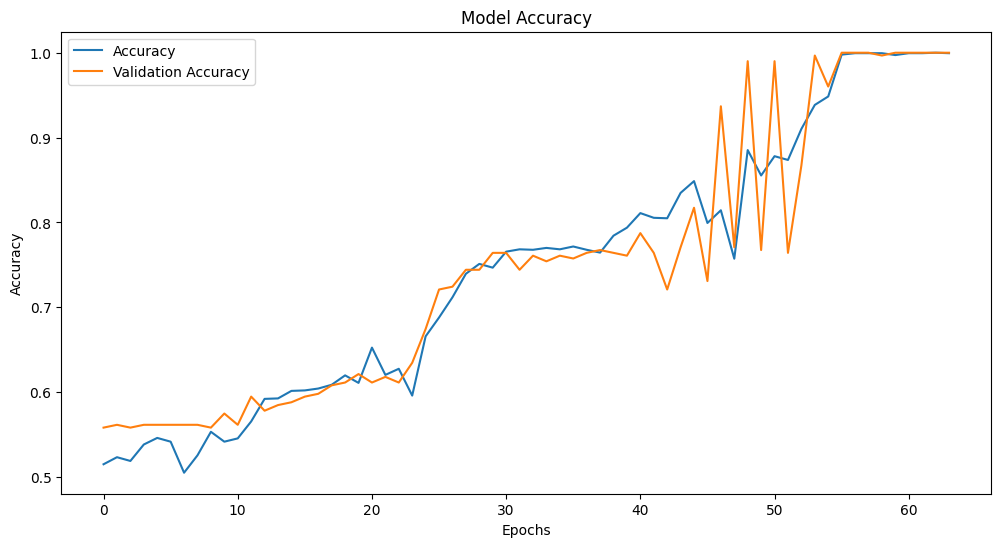

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

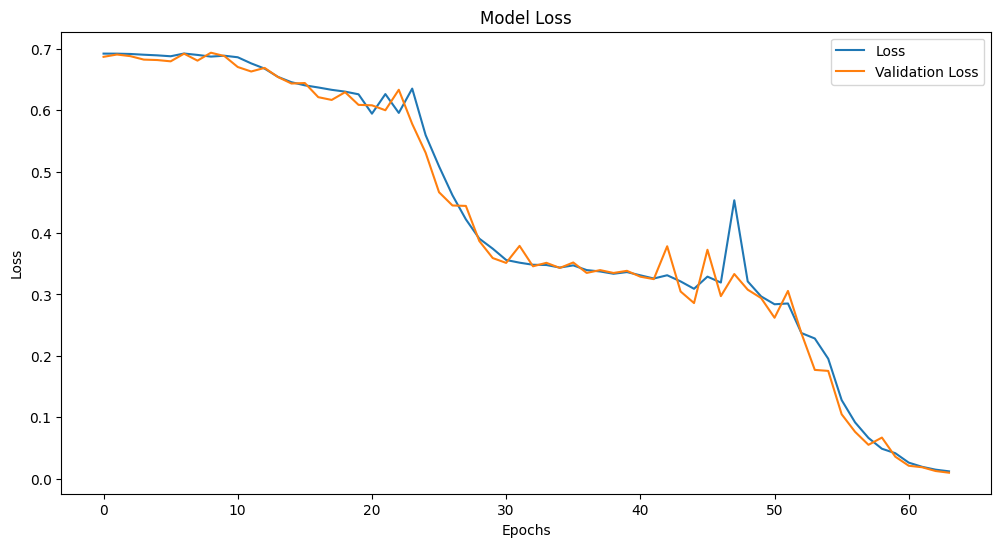

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [15]:
model.evaluate(X_test, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0092


[0.009374077431857586, 1.0]

In [16]:
model.save('models/cnn_1.0_4000hz_f32_f64_n64_n32_batch32_epochs64.keras')